# VAE for mnist

small proof of concept VAE based on [Kingma and Welling, 2014](https://arxiv.org/abs/1312.6114)

[Transposed convolution visualizations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import itertools
from functools import partial

import matplotlib.pyplot as plt

from importlib import reload

from src import vae as vae_lib
import pickle
import os

In [2]:
torch.has_cuda

True

##  load cifar-10

In [3]:
import torchvision
import torchvision.transforms as transforms

In [62]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x > 0.5,
    lambda x: x.float(),
])

batch_size = 128

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

tensor(0.) tensor(1.)
torch.Size([128, 1, 28, 28])
torch.Size([128])


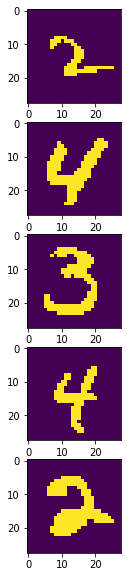

In [61]:
n = 5
plt.figure(figsize=(15, 10))
for i, (X, y) in enumerate(trainloader, start=1):
    plt.subplot(n, 1, i)
    plt.imshow(X[i, 0, :, :])
    if i >= 5:
        print(X.min(), X.max())
        print(X.shape)
        print(y.shape)
        break

##  Training

### create loss histories

In [63]:
loss_histories_path = './saved_models/mnist_loss_histories.pickle'
prefix, ext = os.path.splitext(loss_histories_path)
loss_histories_path_bkup = prefix + '_bkup' + ext
if os.path.exists(loss_histories_path):
    with open(loss_histories_path , 'rb') as f:
        loss_histories = pickle.load(f)
    with open(loss_histories_path_bkup , 'wb') as f:
        pickle.dump(loss_histories, f)
else:
    loss_histories = dict()
loss_histories.keys()

dict_keys(['vae_resent_n5_dmodel64_dz64_mnist', 'vae_resent_n5_dmodel64_dz10_mnist'])

### small model, d_z = 56

In [87]:
reload(vae_lib)

model = vae_lib.VAE(resnet_n=5, d_model=28*2, d_z=28*2, input_channels=1, input_dim=28)
expt_key = 'vae_resent_n5_dmodel64_dz64_mnist_binary'
save_path = f'saved_models/{expt_key}/state_final'
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        model.load_state_dict(torch.load(f))
else:
    vae_lib.init_xavier(model)

for _ in range(10):
    vae_lib.train_epoch(model,
                        loss_histories,
                        expt_key,
                        device='cuda',
                        train_loader=trainloader,
                        test_loader=testloader,
                        save_state_only=True,
                        eval_every=1e5,
                        binary=True,
                   )

100%|██████████| 469/469 [00:46<00:00, 10.24it/s]


60032
binary image: True
                 training loss           23310.9121
                     test loss           29207.2421
                       test kl            3933.3049
             test reconst loss           25273.9372


100%|██████████| 469/469 [00:47<00:00,  9.63it/s]


119936
binary image: True
                 training loss           20798.8613
                     test loss           26488.3545
                       test kl            2098.1304
             test reconst loss           24390.2241


100%|██████████| 469/469 [00:51<00:00,  9.08it/s]


179840
binary image: True
                 training loss           19008.4355
                     test loss           25089.8112
                       test kl            1423.9724
             test reconst loss           23665.8389


100%|██████████| 469/469 [00:49<00:00,  9.35it/s]


239744
binary image: True
                 training loss           18131.1895
                     test loss           23441.1987
                       test kl            1387.0158
             test reconst loss           22054.1828


100%|██████████| 469/469 [00:49<00:00,  9.39it/s]


299648
binary image: True
                 training loss           17546.5332
                     test loss           21865.5514
                       test kl            1582.4085
             test reconst loss           20283.1429


100%|██████████| 469/469 [00:49<00:00,  9.79it/s]


359552
binary image: True
                 training loss           16537.7422
                     test loss           20660.5312
                       test kl            1683.3824
             test reconst loss           18977.1489


100%|██████████| 469/469 [00:58<00:00,  8.08it/s]


419456
binary image: True
                 training loss           15229.1523
                     test loss           19462.0115
                       test kl            1803.3686
             test reconst loss           17658.6429


100%|██████████| 469/469 [00:46<00:00, 10.03it/s]


479360
binary image: True
                 training loss           16692.1367
                     test loss           18643.7449
                       test kl            1881.9971
             test reconst loss           16761.7479


100%|██████████| 469/469 [00:50<00:00, 10.30it/s]


539264
binary image: True
                 training loss           14989.1582
                     test loss           18223.1188
                       test kl            1967.6716
             test reconst loss           16255.4472


100%|██████████| 469/469 [00:47<00:00,  9.97it/s]


599168
binary image: True
                 training loss           14793.6670
                     test loss           17820.4521
                       test kl            2076.9317
             test reconst loss           15743.5205


##  plots

In [12]:
def smooth(arr, window):
    runsum = sum(arr[:window])
    out = [runsum / window]
    i = 0
    j = window

    while j < len(arr):
        runsum -= arr[i]
        runsum += arr[j]
        out.append(runsum / window)
        i += 1
        j += 1

    return out


def plot_loss(xy_pairs, smooth_window=0, **kwargs):
    examples, loss = zip(*xy_pairs)
    if smooth_window > 0:
        loss = smooth(loss, smooth_window)
        examples = examples[:len(loss)]
    plt.plot(examples, loss, **kwargs)

Text(0.5, 1.0, 'dim(z) = 56')

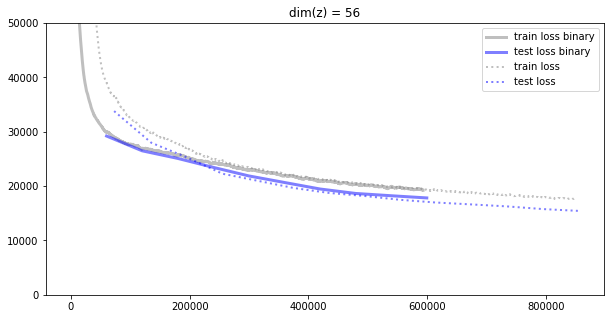

In [94]:
plt.figure(figsize=(10, 5))
plot_loss(
    loss_histories['vae_resent_n5_dmodel64_dz64_mnist_binary']['train_loss'],
    smooth_window=50,
    color='gray',
    linewidth=3,
    alpha=.5)
plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_mnist_binary']
          ['test_loss']['loss'],
          smooth_window=1,
          color='blue',
          linewidth=3,
          alpha=.5)

plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_mnist']['train_loss'],
          smooth_window=50,
          color='gray',
          linewidth=2,
          alpha=.5,
          linestyle=':')
plot_loss(
    loss_histories['vae_resent_n5_dmodel64_dz64_mnist']['test_loss']['loss'],
    smooth_window=1,
    color='blue',
    linewidth=2,
    alpha=.5,
    linestyle=':')

plt.legend([
    'train loss binary',
    'test loss binary',
    'train loss',
    'test loss',
])
plt.ylim([0, 5e4])
plt.title('dim(z) = 56')

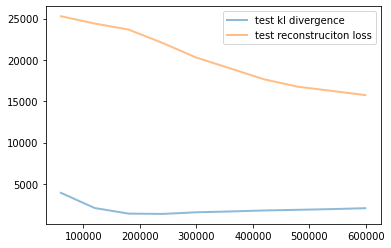

In [95]:
plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_mnist_binary']['test_loss']['kl'],
          smooth_window=1,
          linewidth=2,
          alpha=.5)
plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_mnist_binary']['test_loss']['mse'],
          smooth_window=1,
          linewidth=2,
          alpha=.5)
plt.legend(['test kl divergence', 'test reconstruciton loss'])

In [96]:
loss_histories.keys()

dict_keys(['vae_resent_n5_dmodel64_dz64_mnist', 'vae_resent_n5_dmodel64_dz10_mnist', 'vae_resent_n5_dmodel64_dz64_mnist_binary'])

In [97]:
with open(loss_histories_path, 'wb') as f:
    pickle.dump(loss_histories, f)

## Reconstruction

In [43]:
def to_numpy_img(tensor):
    return tensor.cpu().detach().numpy()[0, :, :, :].transpose(1, 2, 0)

In [74]:
# grab the first batch in the test set
for X, y in testloader:
    break

### grayscale image

Model reconstruction after 1 epoch of training 

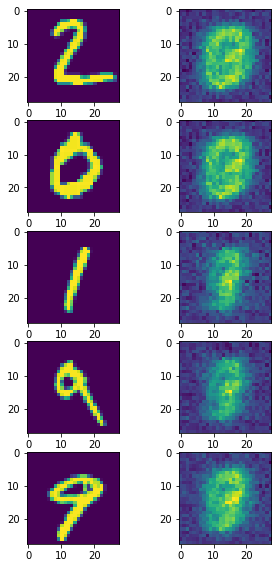

In [22]:
plt.figure(figsize=(5, 20))

model.eval()

for i in range(1, 11, 2):
    img_in = torch.unsqueeze(X[i, :, :, :], 0).to('cuda')
    zu, zs, img_out = model(img_in)
    plt.subplot(10, 2, i)
    plt.imshow(to_numpy_img(img_in))
    plt.subplot(10, 2, i + 1)
    plt.imshow(to_numpy_img(img_out))

model reconstruction after 14 epochs of training showing much better reconstruction

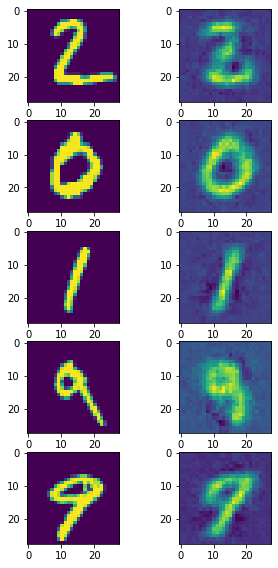

In [33]:
plt.figure(figsize=(5, 20))

model.eval()

for i in range(1, 11, 2):
    img_in = torch.unsqueeze(X[i, :, :, :], 0).to('cuda')
    zu, zs, img_out = model(img_in)
    plt.subplot(10, 2, i)
    plt.imshow(to_numpy_img(img_in))
    plt.subplot(10, 2, i + 1)
    plt.imshow(to_numpy_img(img_out))

### binarized images

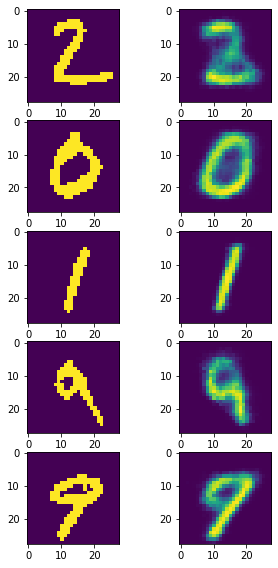

In [98]:
plt.figure(figsize=(5, 20))

model.eval()

for i in range(1, 11, 2):
    img_in = torch.unsqueeze(X[i, :, :, :], 0).to('cuda')
    zu, zs, img_out = model(img_in)
    img_out = torch.sigmoid(img_out)
    plt.subplot(10, 2, i)
    plt.imshow(to_numpy_img(img_in))
    plt.subplot(10, 2, i + 1)
    plt.imshow(to_numpy_img(img_out))

##  sampling

Unsurprisingly sampling the binarized model leads to much better results than the grayscale model

### grayscale

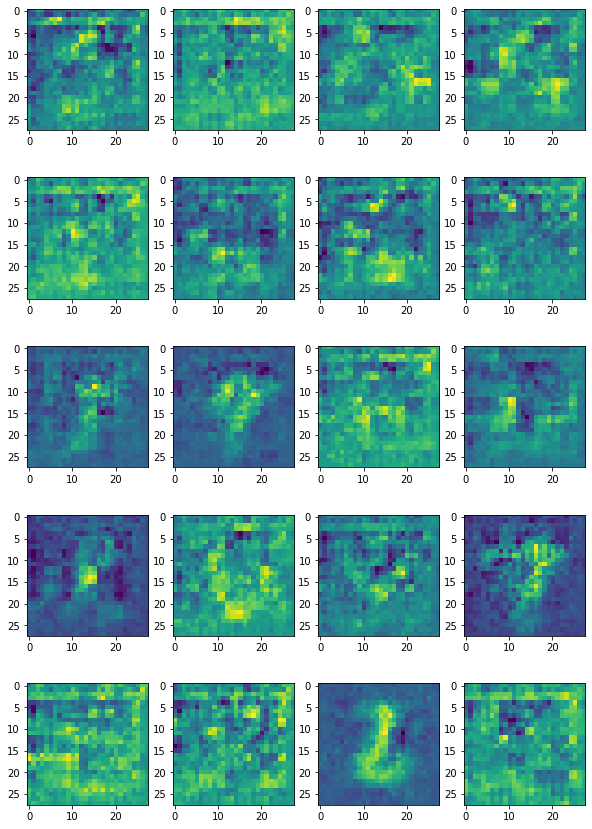

In [35]:
plt.figure(figsize=(10, 15))

model.eval()

for i in range(1, 21):
    plt.subplot(5, 4, i)
    random_img = model.decoder(torch.randn(1, 56, 1, 1).to('cuda'))
    plt.imshow(to_numpy_img(random_img))

### binarized

Discernable numbers can be sampled from the model trained on binarized images.

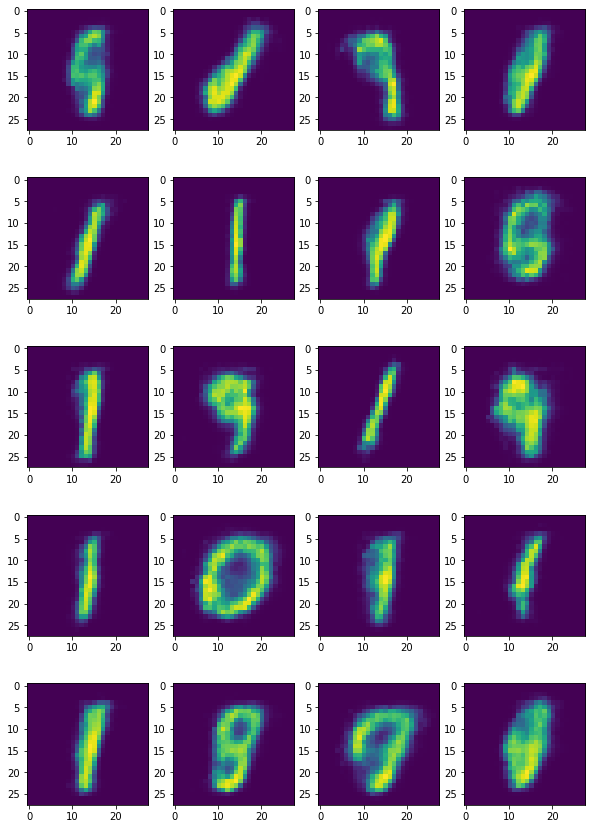

In [102]:
plt.figure(figsize=(10, 15))

model.eval()

for i in range(1, 21):
    plt.subplot(5, 4, i)
    random_img = model.decoder(torch.randn(1, 56, 1, 1).to('cuda'))
    plt.imshow(to_numpy_img(torch.sigmoid(random_img)))

## Visualizing latent space

In [103]:
from sklearn.manifold import TSNE

In [119]:
model.eval()
latents = []
labels = []
for X, y in testloader:
    z_u, _, _ = model(X.to('cuda'))
    latents.append(z_u.cpu().detach().numpy())
    labels.append(y)

In [128]:
latents = np.concatenate(latents)

In [131]:
labels = np.concatenate(labels)

In [ ]:
embed = TSNE().fit_transform(latents)

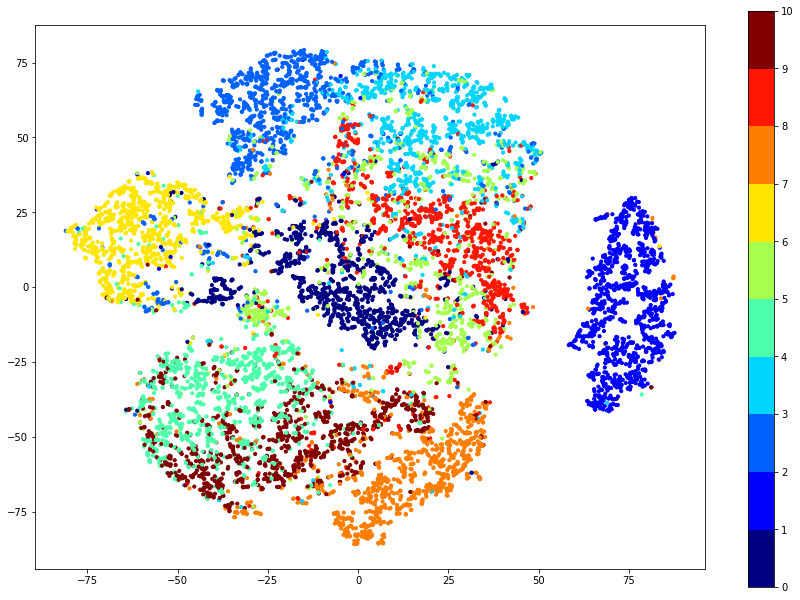

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.scatter(*zip(*embed), c=labels, cmap=cmap, norm=norm, s=10)

cmap = plt.cm.jet
bounds = np.linspace(0, 10, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

## interpolate between numbers

Pick some random latents for interpolation

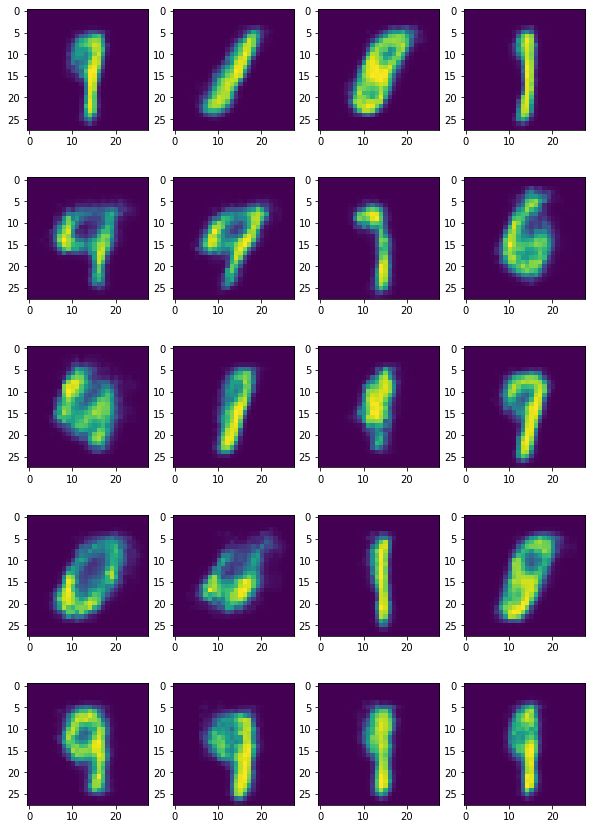

In [190]:
plt.figure(figsize=(10, 15))

model.eval()

random_latents = torch.randn(20, 56, 1, 1)
for i in range(1, 21):
    plt.subplot(5, 4, i)
    lat = torch.unsqueeze(random_latents[i-1, :, :, :], 0)
    random_img = model.decoder(lat.to('cuda'))
    plt.imshow(to_numpy_img(torch.sigmoid(random_img)))

Positions 3 and 4 look promising: 

In [196]:
lat_one = torch.unsqueeze(random_latents[3, :, :, :], 0)
lat_nine = torch.unsqueeze(random_latents[4, :, :, :], 0)

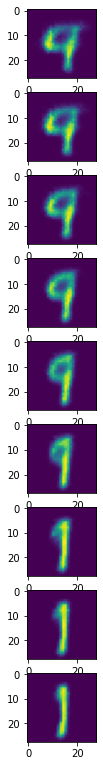

In [209]:
plt.figure(figsize=(15, 15))
rs = np.linspace(0, 1, 9)
for i, r in enumerate(rs, start=1):
    plt.subplot(10, 1, i)
    interp = lat_one * r + lat_nine * (1-r)
    random_img = model.decoder(interp.to('cuda'))
    plt.imshow(to_numpy_img(torch.sigmoid(random_img)))